# Common Average Reference 實作

In [1]:
import scipy.io as scio
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from pandas import *
from pylab import *
from scipy.signal import hilbert, chirp, butter, filtfilt, stft
%matplotlib inline  

In [2]:
def c_correlate(s_1, s_2, lags): # 計算相關係數的函數，只計算 lag = 0 ms。
    """
    Numpy implementation of c_correlate.pro IDL routine
    """
    # ensure signals are of equal length
    assert s_1.shape == s_2.shape
    n_s = s_1.shape[0]
    # center both signals
    s_1_center = s_1 - s_1.mean()
    s_2_center = s_2 - s_2.mean()
    # allocate space for correlation
    correlation = np.zeros(lags.shape)
    # iterate over lags
    for i,l in enumerate(lags):
        if l >= 0:
            tmp = s_1_center[:(n_s - l)] * s_2_center[l:]
        else:
            tmp = s_1_center[-l:] * s_2_center[:(n_s + l)]
        correlation[i] = tmp.sum()
    # Divide by standard deviation of both
    correlation /= np.sqrt((s_1_center**2).sum() * (s_2_center**2).sum())
    
    return correlation

一開始先把全部的訊號畫出，以數值上下限為依據，挑選差不多order的數據。(大約落在$\pm$10000)

In [3]:
inputf = open("data_by_car.out", 'rb')
npzfile = np.load(inputf)
npzfile.files
t = npzfile['arr_0']
tdata = npzfile['arr_1']
good_data_list = npzfile['arr_2']
cc  = npzfile['arr_3'] 
ccp = npzfile['arr_4'] 
car = npzfile['arr_5']
average = npzfile['arr_6']

In [4]:
fs = 1000
N = len(good_data_list)
n = len(tdata[0])
t = np.arange(n) / fs
lag = np.arange(1)


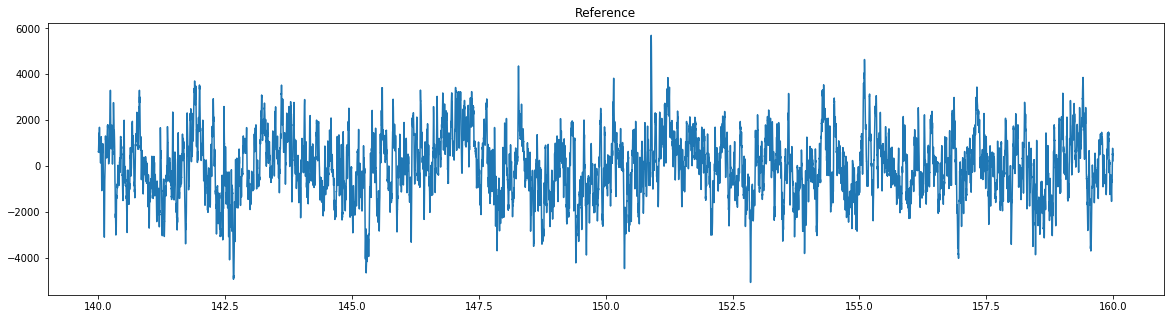

In [5]:
plt.figure(figsize = (20, 5))
plt.title("Reference")
plt.plot(t[140000:160000],average[140000:160000])
plt.show()

cca = np.zeros(N)
ii = 0
for i in good_data_list:
    A = tdata[i]
    B = average
    cca[ii] = c_correlate(A,B,lag)[0]
    ii += 1

# compare with origial signals

In [6]:
def Cubic_Spline_Interpolation(x, y, ox): #datax, datay, ouputx
    x = np.array(x)
    y = np.array(y)
    n = len(x)

    # Tridiagonal matrix
    h = x[1:n] - x[0:n-1] #n-1
    g = (y[1:n] - y[0:n-1]) / h[0:n-1] #n-1
    gg = g[1:n-1]-g[0:n-2] #n-2
    d = np.zeros(n)
    d[1:n-1] = 6*gg
    a = np.zeros(n)
    b = np.zeros(n)
    c = np.zeros(n)
    b[0] = b[n-1] = 1

    for i in range(n-2):
        a[i+1] = h[i]
        b[i+1] = 2*(h[i]+h[i+1])
        c[i+1] = h[i+1]

    cp = np.zeros(n-1)
    dp = np.zeros(n)
    m = np.zeros(n)

    cp[0] = c[0]/b[0]
    dp[0] = d[0]/b[0]
    for i in range(n-2):
        cp[i+1] = c[i+1]/(b[i+1] - a[i+1]*cp[i])
        dp[i+1] = (d[i+1] - a[i+1]*dp[i]) / (b[i+1] - a[i+1]*cp[i])

    m[n-1] = dp[n-1]
    for i in range(n-2, -1, -1):
        m[i] = dp[i] - cp[i] * m[i+1]

    sa = y[0:n-1]
    sb = (y[1:n] - y[0:n-1])/h[0:n-1]-h[0:n-1]*m[0:n-1]/2.0-(m[1:n] - m[0:n-1])*h[0:n-1]/6.0
    sc = m[0:n-1]/2
    sd = (m[1:n] - m[0:n-1])/(6*h[0:n-1])
  
    xp = ox
    yp = np.zeros(len(xp))
    idx = 0
  
    for i in range(len(xp)):
        while idx < n-2 and xp[i] >= x[idx+1]:
            idx += 1
        if idx >= n-2:
            idx = n-2
        xnow = xp[i]-x[idx]
        yp[i] = sa[idx]+sb[idx]*xnow+sc[idx]*(xnow**2)+sd[idx]*(xnow**3)

    return yp

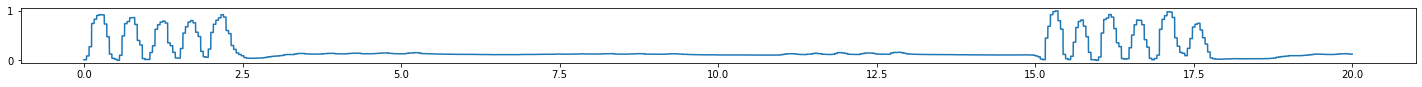

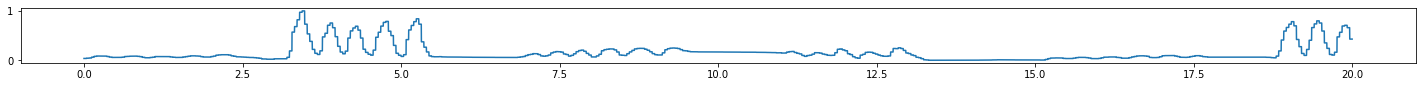

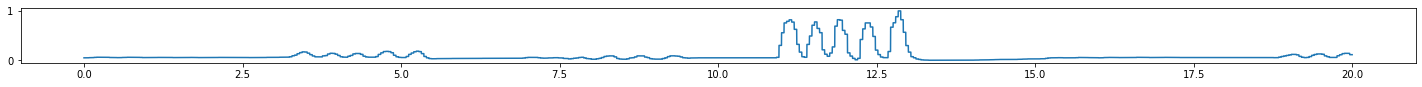

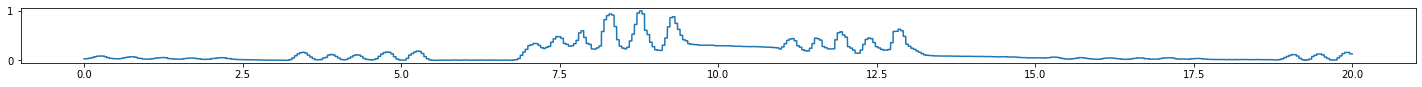

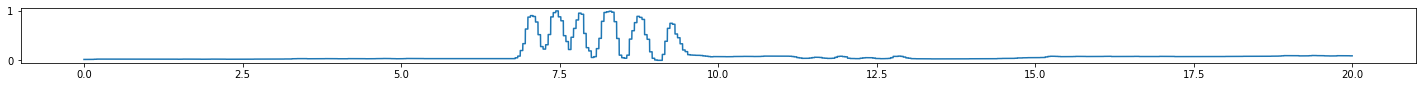

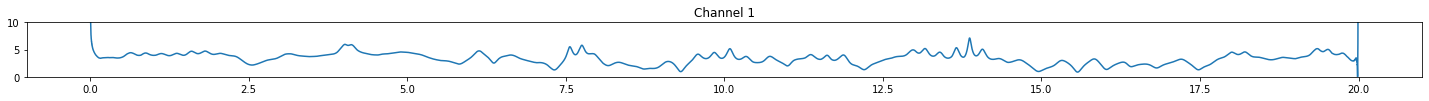

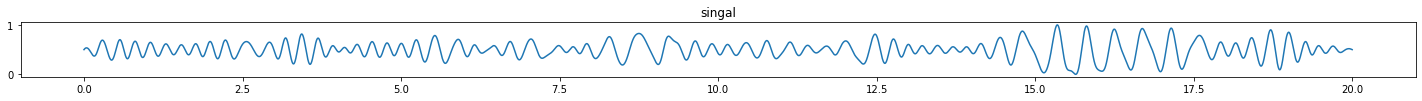

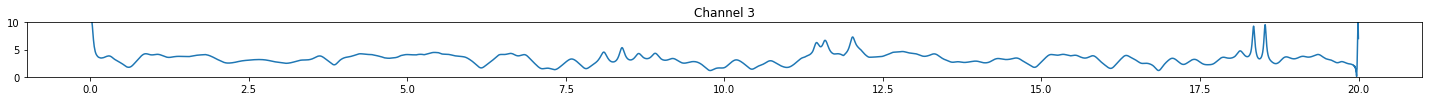

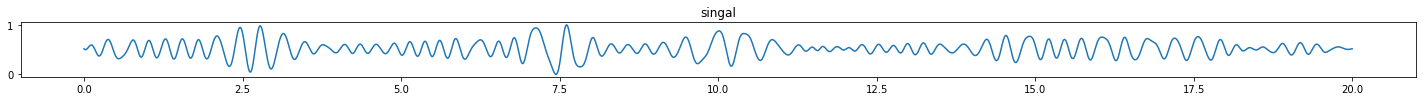

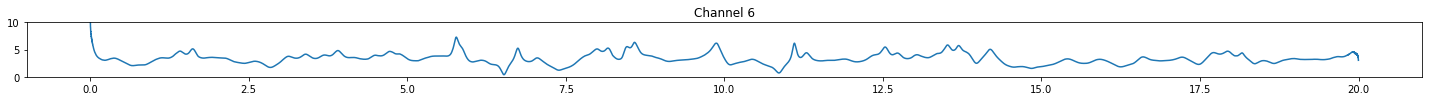

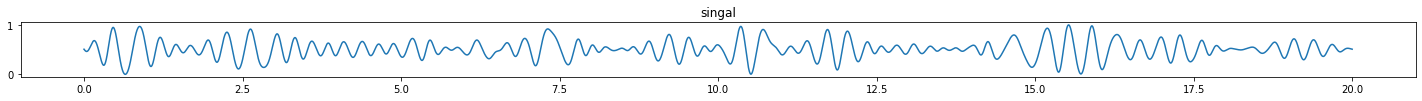

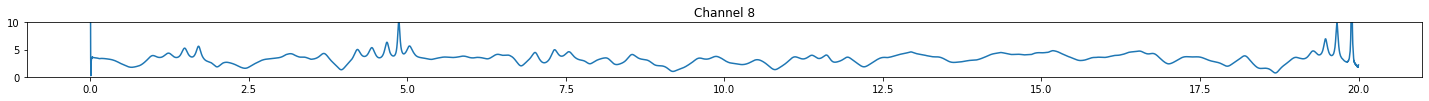

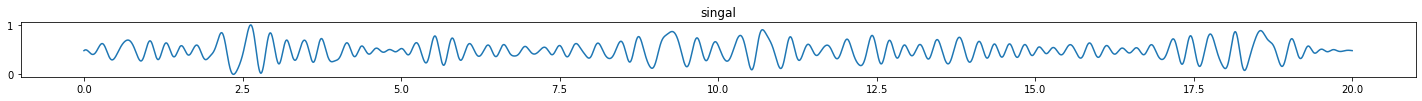

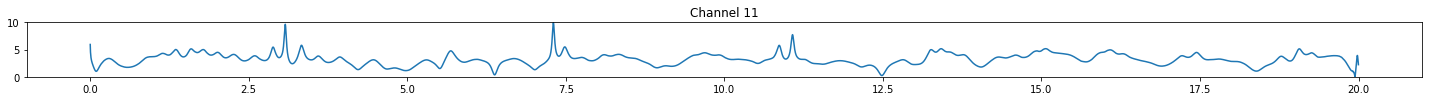

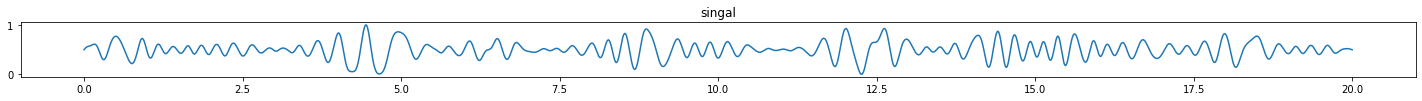

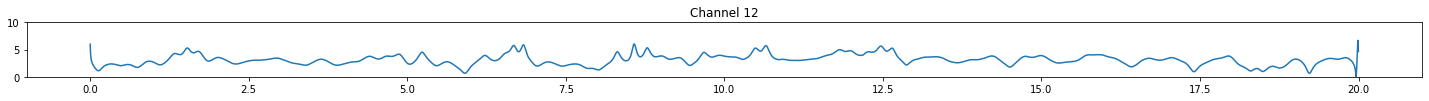

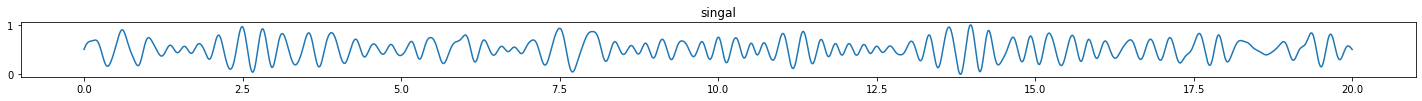

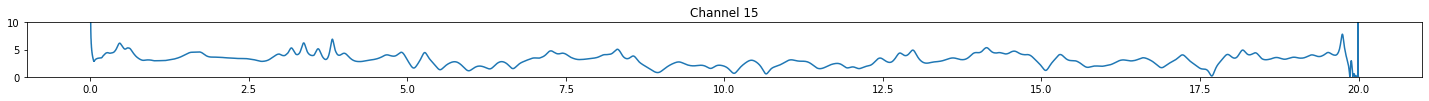

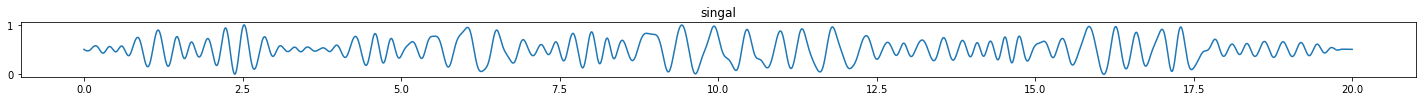

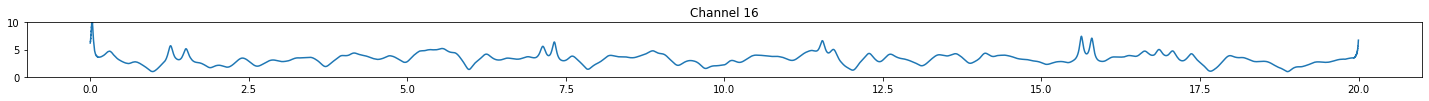

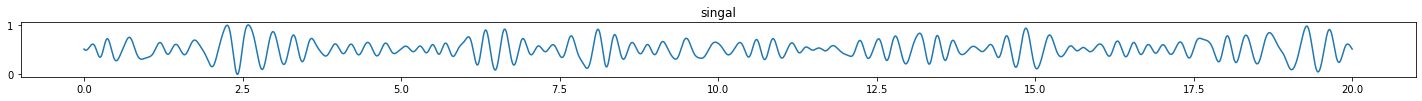

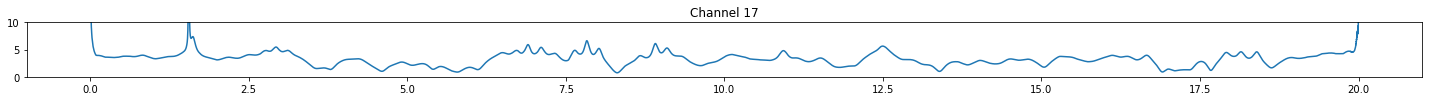

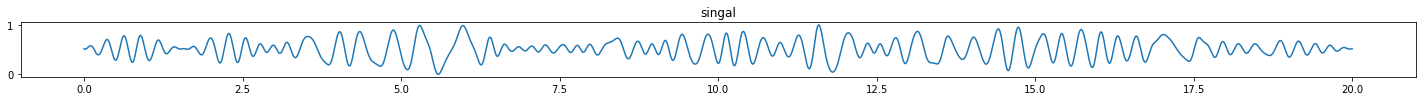

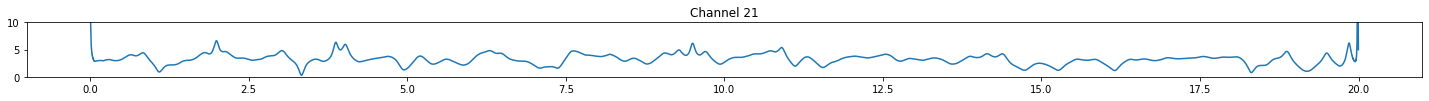

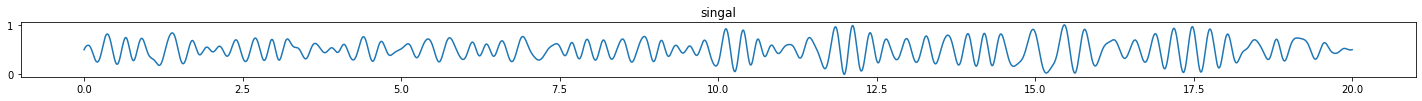

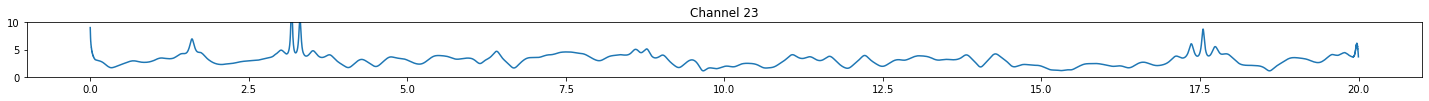

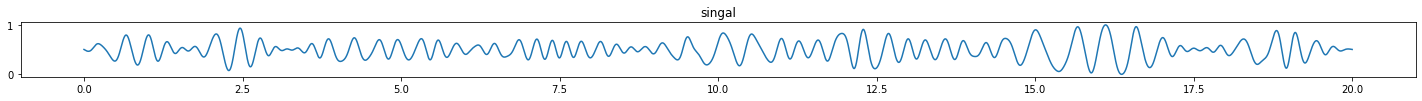

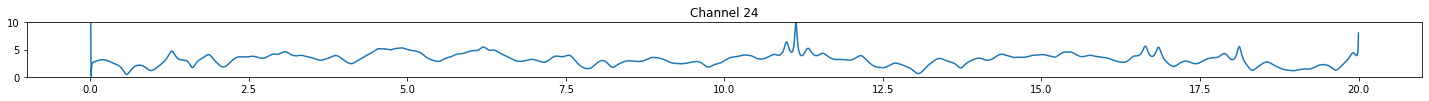

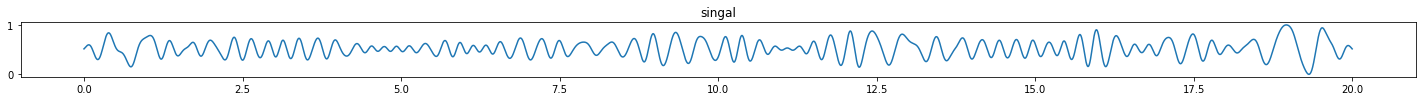

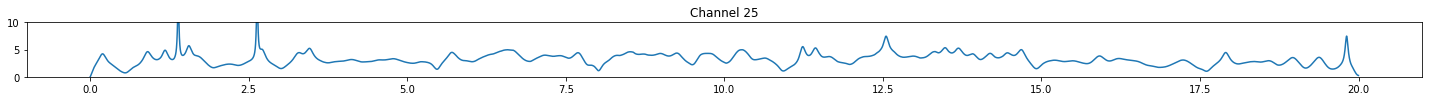

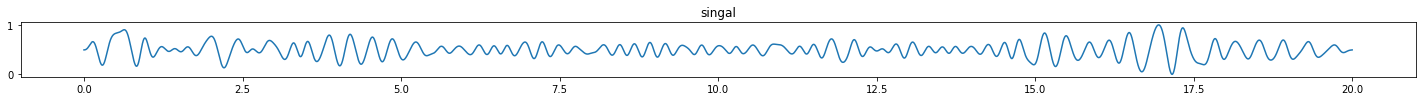

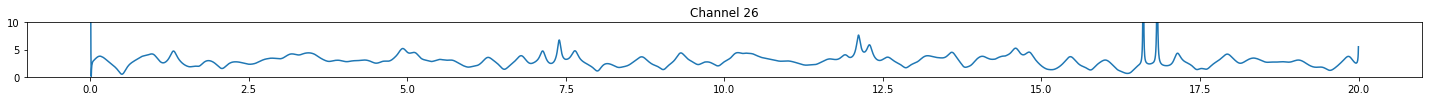

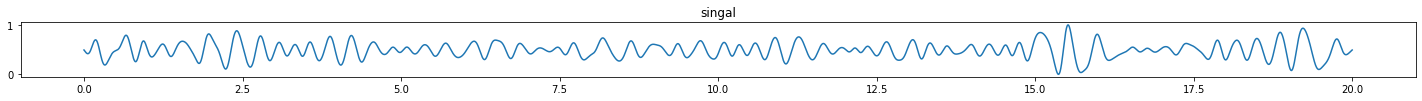

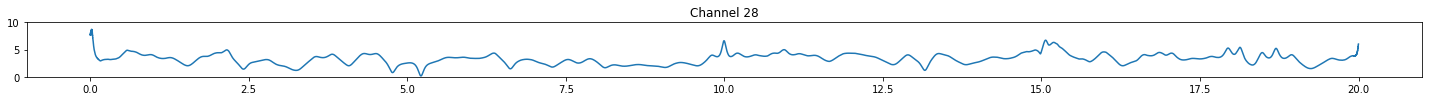

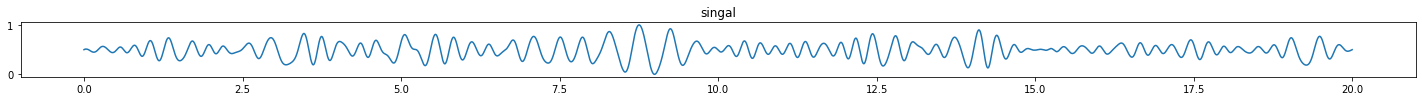

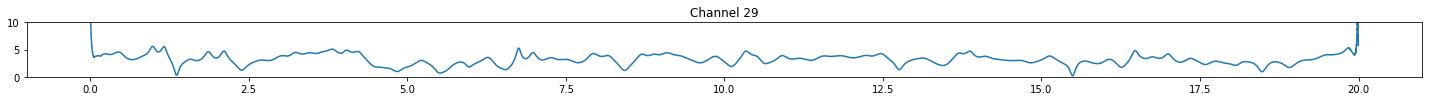

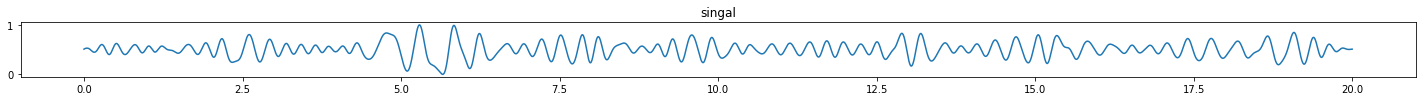

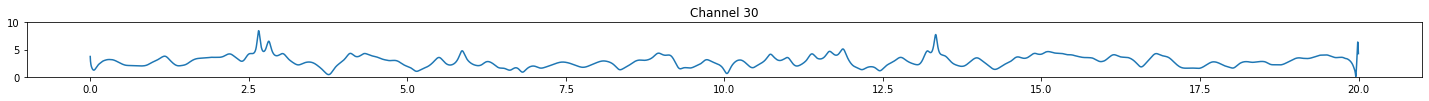

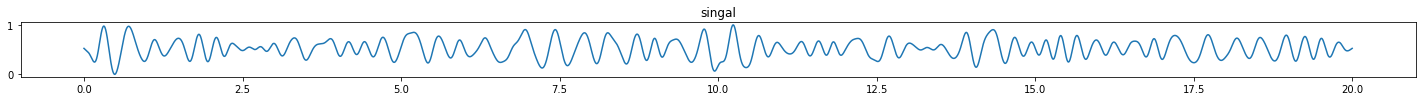

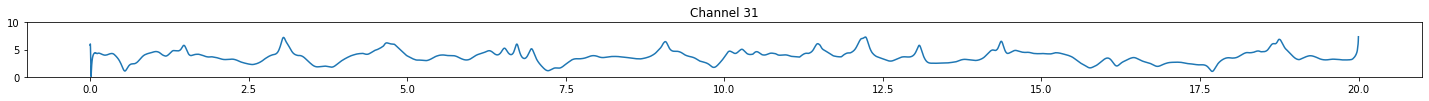

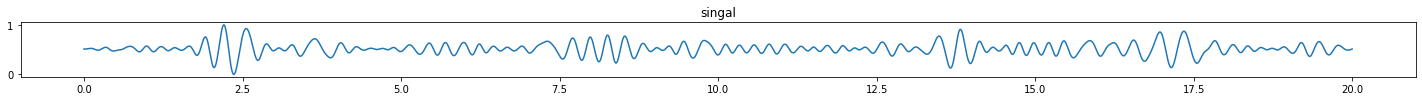

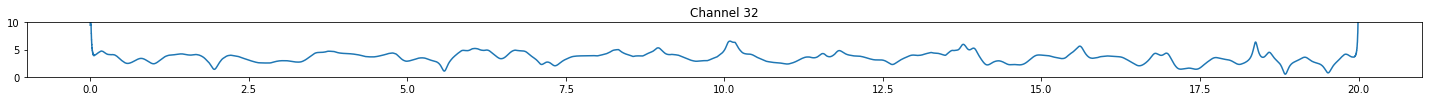

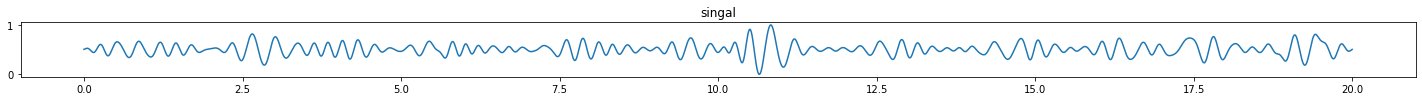

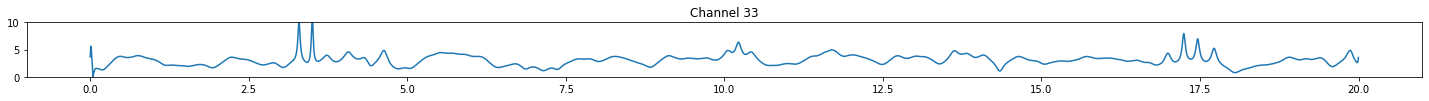

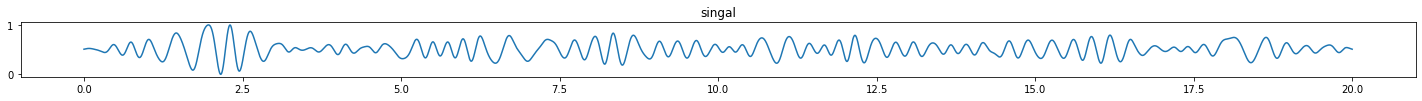

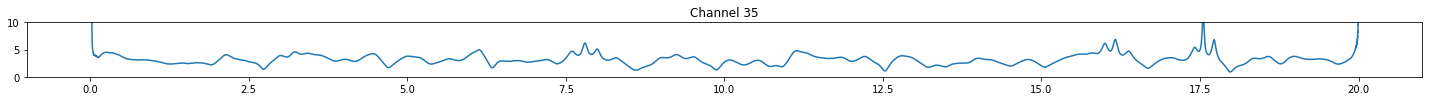

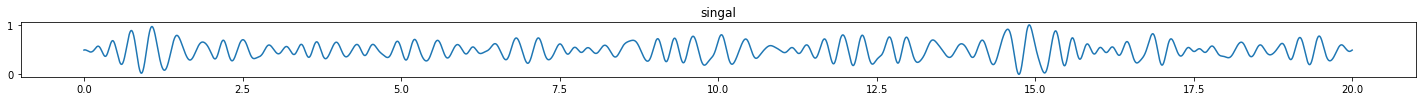

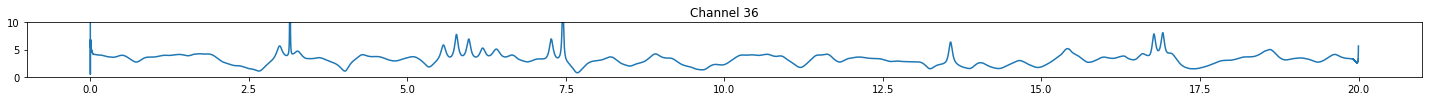

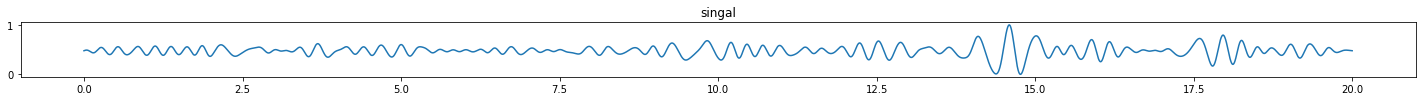

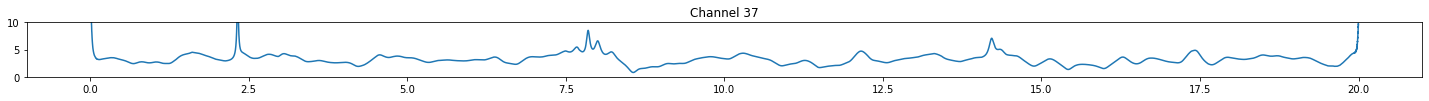

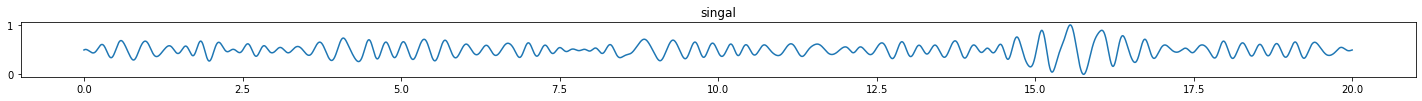

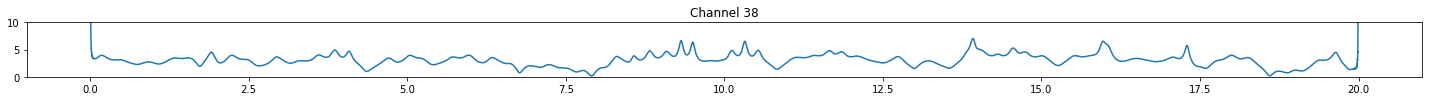

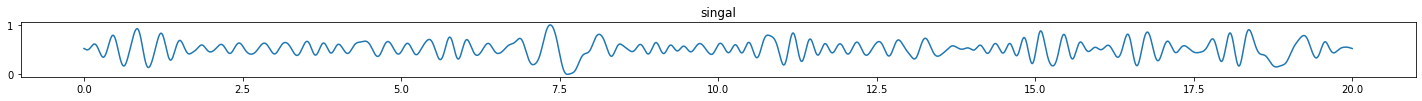

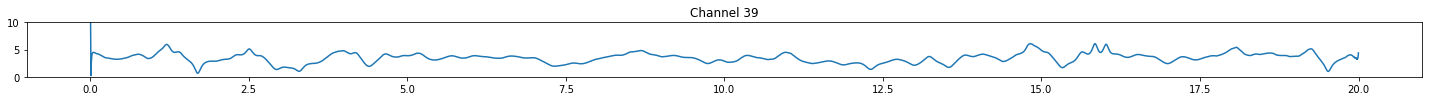

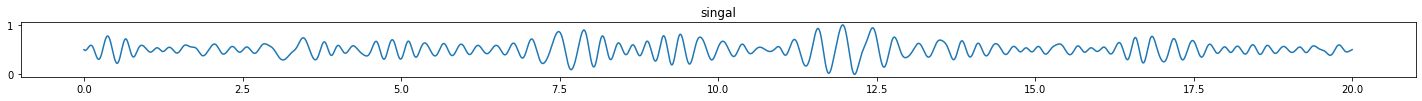

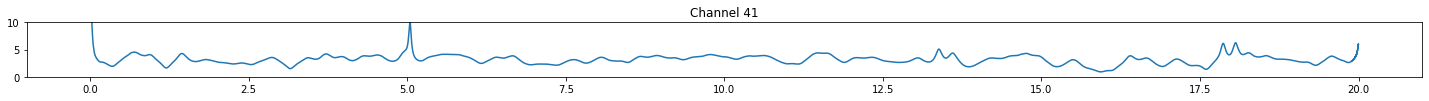

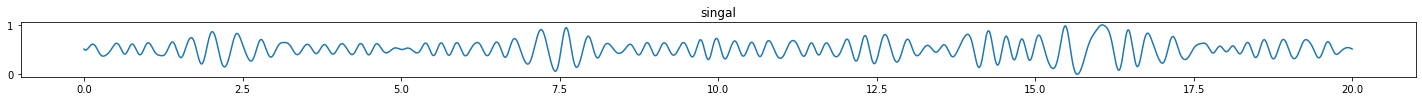

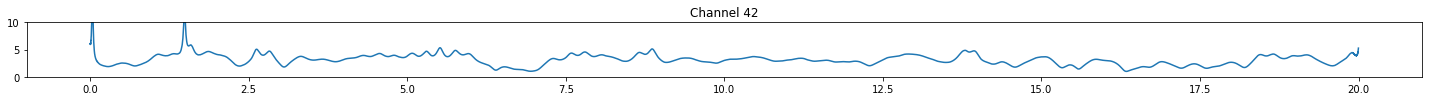

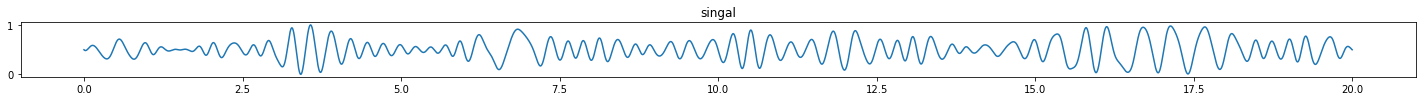

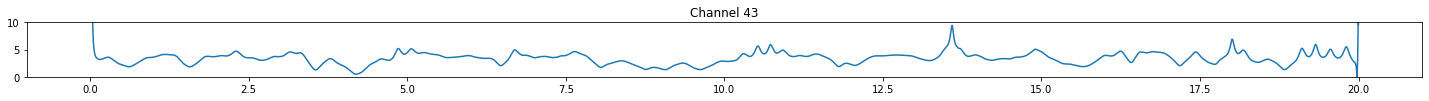

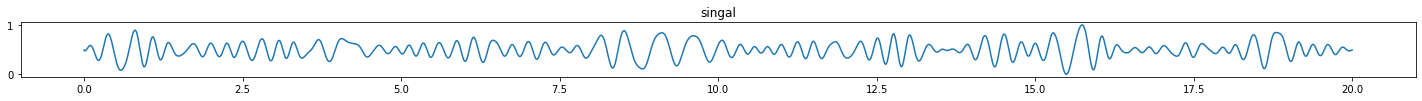

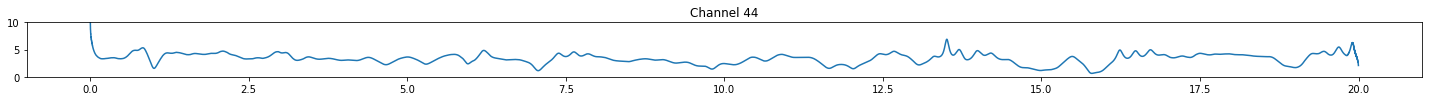

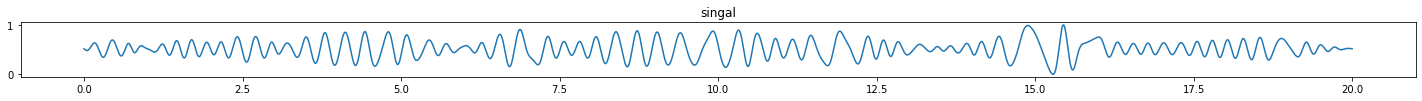

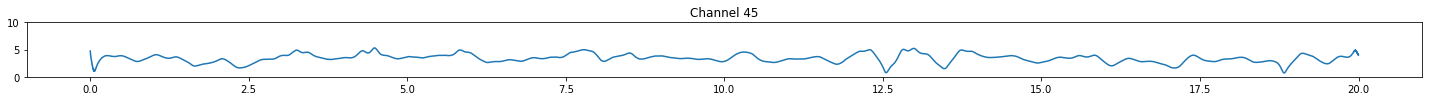

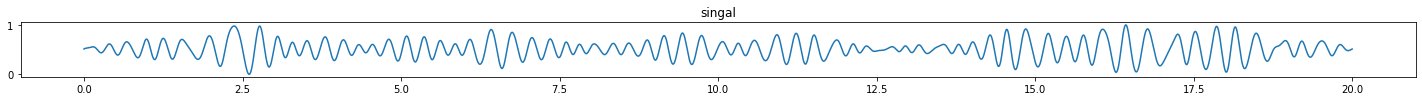

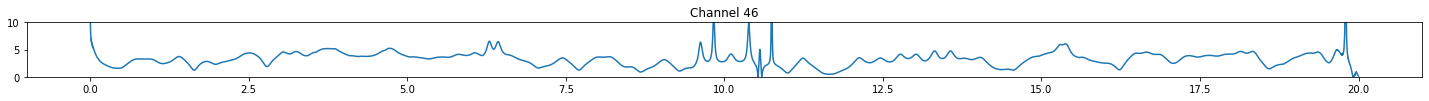

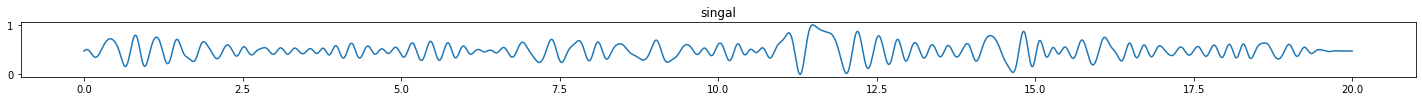

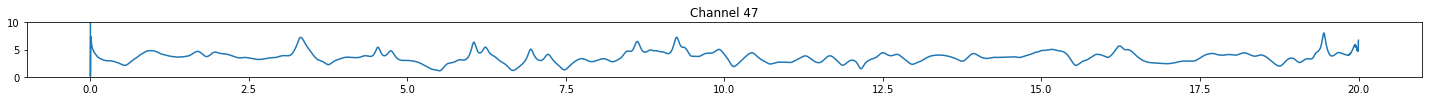

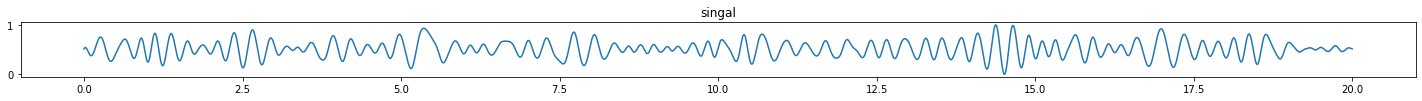

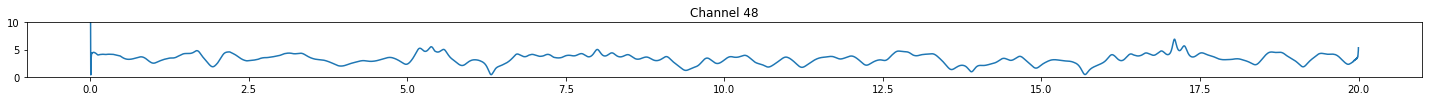

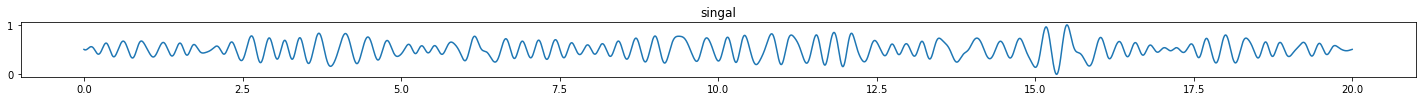

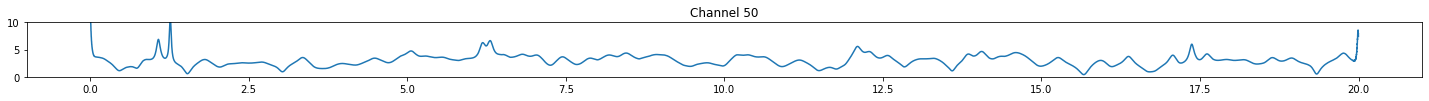

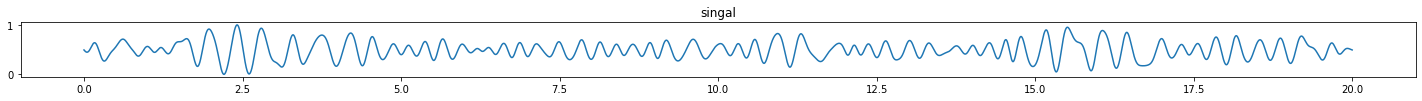

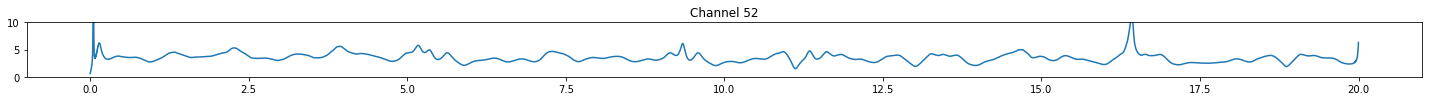

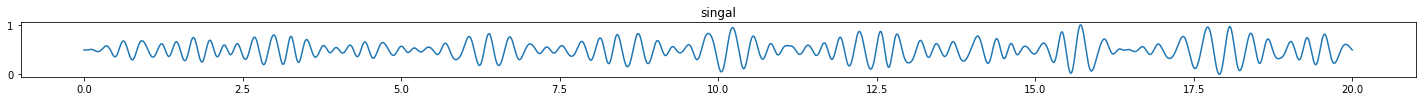

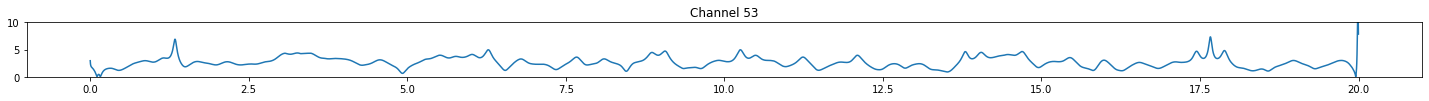

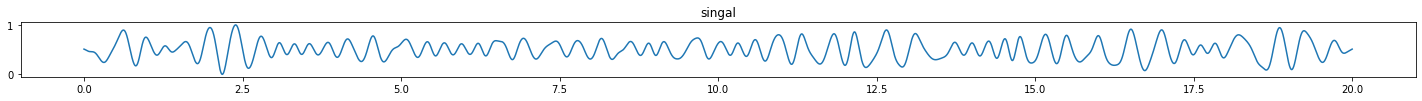

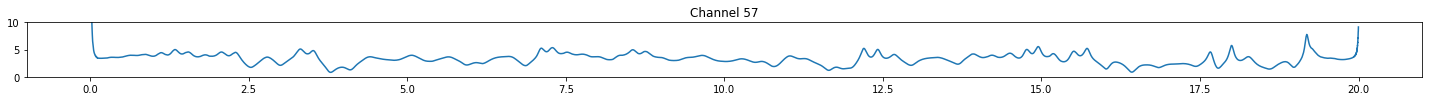

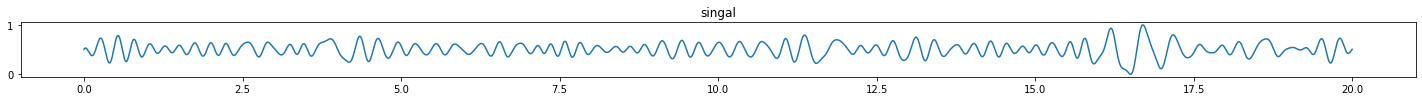

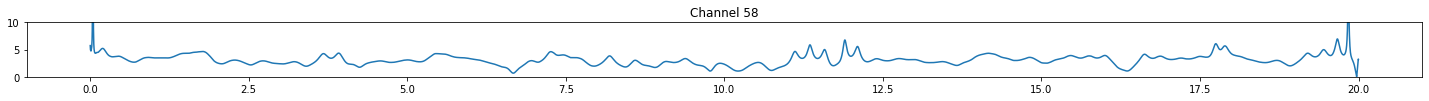

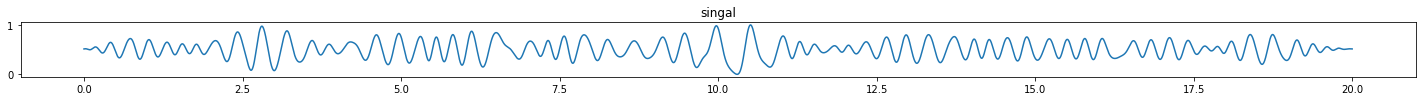

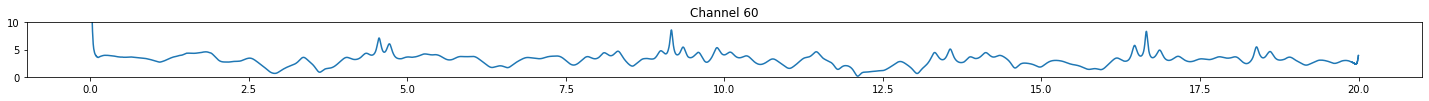

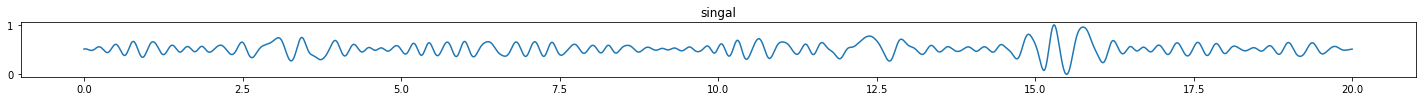

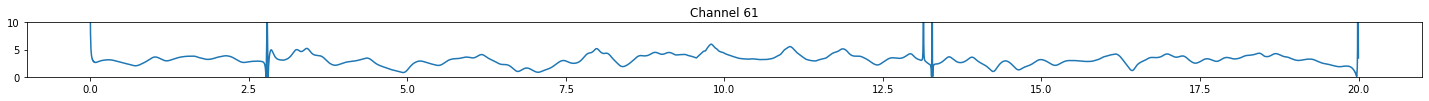

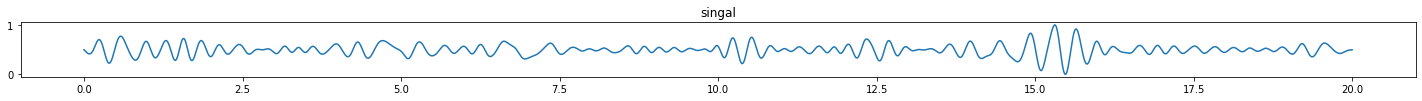

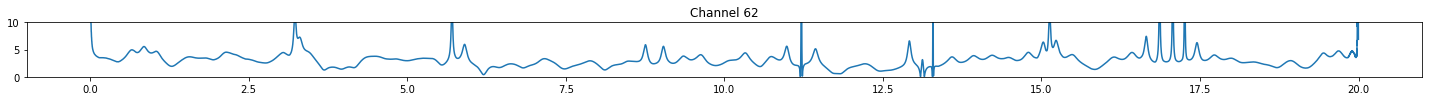

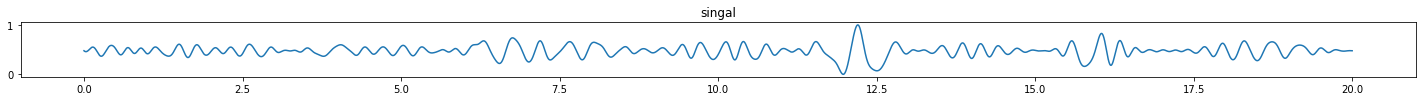

In [15]:
IMF = []
duration = 20
fs = 1000.0
nf = fs/2
cutoff = 4
_b,_a = butter(4, cutoff/nf)
samples = int(fs*duration)
t = np.arange(samples) / fs
n = len(t)
fiter = filtfilt

dataFile='sub1_comp.mat'
data=scio.loadmat(dataFile)
for i in range(5):
    plt.figure(figsize=(25,1))
    t = np.arange(n) / fs
    dd = data["train_dg"].T[i][140000:160000]
    plt.plot(t, (dd-min(dd))/(max(dd)-min(dd)))
    plt.show()
    
for ii in range(len(good_data_list)):
    
    signal = fiter(_b, _a,car[ii][140000:160000])
    xx = np.array(t)
    yy = np.array(signal)
    yo = yy

    times = 50
    while times > 0:
        times -= 1
        peaks_num = 0
        x = []
        y = []
        for i in range(len(xx)):
            if i == 0 or i == len(xx)-1  or ( yy[i] < yy[i-1] and yy[i] < yy[i+1]):
                x.append(xx[i])
                y.append(yy[i])
        ylow = Cubic_Spline_Interpolation(x, y, xx)
        peaks_num += len(y)

        x = []
        y = []
        for i in range(len(xx)):
            if i == 0 or i == len(xx)-1  or ( yy[i] > yy[i-1] and yy[i] > yy[i+1]):
                x.append(xx[i])
                y.append(yy[i])
        yup = Cubic_Spline_Interpolation(x, y, xx)
        peaks_num += len(y)

        ymid = 0.5*ylow+0.5*yup


        yy = yy - ymid



    analytic_signal = hilbert(yy)
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs)

    plt.figure(figsize=(25,1))
    plt.title('Channel '+str(good_data_list[ii]+1))
    #yyy = amplitude_envelope
    #yyyy = (yyy-min(yyy))/(max(yyy)-min(yyy))
    yyyy = (yy-min(yy))/(max(yy)-min(yy))
    plt.ylim(0, 10)
    plt.plot( xx[1:-2], abs(instantaneous_frequency[0:-2]))
    plt.show()
    #NF = fs / 2
    #cutoff = 2
    #b, a = butter(2, cutoff/nf)
    #A = filtfilt(b, a, abs(instantaneous_frequency))

    plt.figure(figsize=(25,1))
    plt.title('singal')
    plt.plot(xx, yyyy)
    #plt.ylim(0, 20.0)
    plt.show()